<a href="https://colab.research.google.com/github/ankitmaurya001/Time-series-prediction/blob/master/EDA_diabetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this document is to do indepth analysis of gradability for __diabetic patients and age >50__. The idea is to figure out what type of patients are pulling the gradability down, so that proper actions could be taken.

In [ ]:
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
from scipy.stats import chi2

In [ ]:
GRADABILITY_AI_PATH = Path('../data/results_ensemble_ai_diabetes.csv')
PATIENT_INFO_PATH = Path('../data/patient_details_combined.csv')

### Basic metrics

In [ ]:
df_gradability = pd.read_csv(GRADABILITY_AI_PATH)
df_gradability = df_gradability[1:] ## removing the first row as it's not a falcon image
df_patient = pd.read_csv(PATIENT_INFO_PATH)

In [ ]:
df_gradability.shape, df_patient.shape

((11249, 8), (11326, 14))

In [ ]:
df_gradability.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11249 entries, 1 to 11249
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            11249 non-null  object 
 1   softmax_good    11249 non-null  float64
 2   softmax_usable  11249 non-null  float64
 3   softmax_bad     11249 non-null  float64
 4   good_sd         11249 non-null  float64
 5   usable_sd       11249 non-null  float64
 6   bad_sd          11249 non-null  float64
 7   Prediction      11249 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 703.2+ KB


In [ ]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11326 entries, 0 to 11325
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image_id            11326 non-null  int64  
 1   visit_id            11326 non-null  int64  
 2   age                 11326 non-null  int64  
 3   gender              11326 non-null  object 
 4   pupil_size          11186 non-null  float64
 5   eye                 11326 non-null  object 
 6   gaze                11326 non-null  object 
 7   dm_onset            11326 non-null  object 
 8   hypertension_onset  6598 non-null   object 
 9   cataract_od         3150 non-null   object 
 10  cataract_os         3176 non-null   object 
 11  dr_grading_od       10893 non-null  object 
 12  dr_grading_os       10893 non-null  object 
 13  location_name       11326 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 1.2+ MB


There seems to be some null values for pupil size, removing the rows where pupil size is none

In [ ]:
df_patient = df_patient.dropna(axis= 0, subset= ['pupil_size'])

In [ ]:
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11186 entries, 0 to 11325
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image_id            11186 non-null  int64  
 1   visit_id            11186 non-null  int64  
 2   age                 11186 non-null  int64  
 3   gender              11186 non-null  object 
 4   pupil_size          11186 non-null  float64
 5   eye                 11186 non-null  object 
 6   gaze                11186 non-null  object 
 7   dm_onset            11186 non-null  object 
 8   hypertension_onset  6536 non-null   object 
 9   cataract_od         3010 non-null   object 
 10  cataract_os         3036 non-null   object 
 11  dr_grading_od       10753 non-null  object 
 12  dr_grading_os       10753 non-null  object 
 13  location_name       11186 non-null  object 
dtypes: float64(1), int64(3), object(10)
memory usage: 1.3+ MB


In [ ]:
df_gradability.head(2)

,Name,softmax_good,softmax_usable,softmax_bad,good_sd,usable_sd,bad_sd,Prediction
1,../Results/M0/images/production_10001_5250_ai_...,0.821683,0.134455,0.043862,0.164976,0.113438,0.064649,0
2,../Results/M0/images/production_10002_5250_ai_...,0.030924,0.117743,0.851333,0.048425,0.122697,0.170402,2


In [ ]:
df_patient.head(2)

,image_id,visit_id,age,gender,pupil_size,eye,gaze,dm_onset,hypertension_onset,cataract_od,cataract_os,dr_grading_od,dr_grading_os,location_name
0,23900,10755,65,F,4.18,r,center,2018-08-10,2008-08-10,NaN,NaN,Inconclusive,Inconclusive,{'Idrishti@Apollo clinic-Sarjapur'}
1,23899,10755,65,F,3.58,l,center,2018-08-10,2008-08-10,NaN,NaN,Inconclusive,Inconclusive,{'Idrishti@Apollo clinic-Sarjapur'}


In [ ]:
## Extract image_id and visit_id from gradability from df_gradability to obtain a common column for merging
df_gradability['imageid_visitid'] = df_gradability['Name'].apply(lambda x : x.split('/')[-1].split('_')[1] + '_'
                                                                 + x.split('/')[-1].split('_')[2])

In [ ]:
df_gradability.head(1)

,Name,softmax_good,softmax_usable,softmax_bad,good_sd,usable_sd,bad_sd,Prediction,imageid_visitid
1,../Results/M0/images/production_10001_5250_ai_...,0.821683,0.134455,0.043862,0.164976,0.113438,0.064649,0,10001_5250


In [ ]:
## Do the same for df_patient
df_patient['imageid_visitid'] =  df_patient['image_id'].apply(str) + '_' + df_patient['visit_id'].apply(str)

In [ ]:
df_patient.head(1)

,image_id,visit_id,age,gender,pupil_size,eye,gaze,dm_onset,hypertension_onset,cataract_od,cataract_os,dr_grading_od,dr_grading_os,location_name,imageid_visitid
0,23900,10755,65,F,4.18,r,center,2018-08-10,2008-08-10,NaN,NaN,Inconclusive,Inconclusive,{'Idrishti@Apollo clinic-Sarjapur'},23900_10755


In [ ]:
## Merging both the dataframes on imageid_visitid
merged_inner = pd.merge(left = df_gradability, right = df_patient, left_on= 'imageid_visitid', right_on= 'imageid_visitid')

In [ ]:
merged_inner.shape

(11180, 23)

The analysis is based on __11,180 images.__

In [ ]:
merged_inner.head()

,Name,softmax_good,softmax_usable,softmax_bad,good_sd,usable_sd,bad_sd,Prediction,imageid_visitid,image_id,...,pupil_size,eye,gaze,dm_onset,hypertension_onset,cataract_od,cataract_os,dr_grading_od,dr_grading_os,location_name
0,../Results/M0/images/production_10001_5250_ai_...,0.821683,0.134455,0.043862,0.164976,0.113438,0.064649,0,10001_5250,10001,...,4.86,l,center,2008-05-25,2008-05-25,NaN,NaN,Inconclusive,Grade 1: No DR,{'Minto'}
1,../Results/M0/images/production_10002_5250_ai_...,0.030924,0.117743,0.851333,0.048425,0.122697,0.170402,2,10002_5250,10002,...,4.80,l,right,2008-05-25,2008-05-25,NaN,NaN,Inconclusive,Grade 1: No DR,{'Minto'}
2,../Results/M0/images/production_10003_5250_ai_...,0.341106,0.394536,0.264357,0.183259,0.109443,0.210638,1,10003_5250,10003,...,4.85,l,center,2008-05-25,2008-05-25,NaN,NaN,Inconclusive,Grade 1: No DR,{'Minto'}
3,../Results/M0/images/production_10004_5250_ai_...,0.439923,0.303645,0.256432,0.273453,0.129867,0.260522,0,10004_5250,10004,...,6.49,r,right,2008-05-25,2008-05-25,NaN,NaN,Inconclusive,Grade 1: No DR,{'Minto'}
4,../Results/M0/images/production_10005_5250_ai_...,0.005226,0.030129,0.964646,0.010900,0.037482,0.047673,2,10005_5250,10005,...,6.39,r,center,2008-05-25,2008-05-25,NaN,NaN,Inconclusive,Grade 1: No DR,{'Minto'}


In [ ]:
eye_map = {'r' : 'od', 'l': 'os'}

In [ ]:
merged_inner['cataract'] = merged_inner.apply(lambda x : x[f"cataract_{eye_map[x['eye']]}"], axis = 1)

In [ ]:
merged_inner['dr_grading'] =  merged_inner.apply(lambda x : x[f"dr_grading_{eye_map[x['eye']]}"], axis = 1)

In [ ]:
merged_inner['HT'] = merged_inner.apply(lambda x : True if x['hypertension_onset'] is not np.nan  else False , axis = 1)

In [ ]:
merged_inner[['eye', 'cataract_od', 'cataract_os','dr_grading_od', 'dr_grading_os', 'cataract', 'dr_grading' , 'HT', 'hypertension_onset']].head(16)

,eye,cataract_od,cataract_os,dr_grading_od,dr_grading_os,cataract,dr_grading,HT,hypertension_onset
0,l,NaN,NaN,Inconclusive,Grade 1: No DR,NaN,Grade 1: No DR,True,2008-05-25
1,l,NaN,NaN,Inconclusive,Grade 1: No DR,NaN,Grade 1: No DR,True,2008-05-25
2,l,NaN,NaN,Inconclusive,Grade 1: No DR,NaN,Grade 1: No DR,True,2008-05-25
3,r,NaN,NaN,Inconclusive,Grade 1: No DR,NaN,Inconclusive,True,2008-05-25
4,r,NaN,NaN,Inconclusive,Grade 1: No DR,NaN,Inconclusive,True,2008-05-25
5,l,NaN,NaN,Inconclusive,Inconclusive,NaN,Inconclusive,True,2023-01-25
6,l,NaN,NaN,Inconclusive,Inconclusive,NaN,Inconclusive,True,2023-01-25
7,l,NaN,NaN,Inconclusive,Inconclusive,NaN,Inconclusive,True,2023-01-25
8,l,True,True,Grade 1: No DR,Grade 1: No DR,True,Grade 1: No DR,False,NaN
9,r,True,True,Grade 1: No DR,Grade 1: No DR,True,Grade 1: No DR,False,NaN


In [ ]:
## Add a map for image quality prediction
merged_inner['Prediction_map'] = merged_inner['Prediction'].map({0: 'Good', 1: 'Usable' , 2: 'Reject'})

In [ ]:
merged_inner.columns

Index(['Name', 'softmax_good', 'softmax_usable', 'softmax_bad', 'good_sd',
       'usable_sd', 'bad_sd', 'Prediction', 'imageid_visitid', 'image_id',
       'visit_id', 'age', 'gender', 'pupil_size', 'eye', 'gaze', 'dm_onset',
       'hypertension_onset', 'cataract_od', 'cataract_os', 'dr_grading_od',
       'dr_grading_os', 'location_name', 'cataract', 'dr_grading',
       'Prediction_map', 'DM', 'HT'],
      dtype='object')

In [ ]:
merged_inner.head(1)

,Name,softmax_good,softmax_usable,softmax_bad,good_sd,usable_sd,bad_sd,Prediction,imageid_visitid,image_id,...,dm_onset,hypertension_onset,cataract_od,cataract_os,dr_grading_od,dr_grading_os,location_name,cataract,dr_grading,Prediction_map
0,../Results/M0/images/production_10001_5250_ai_...,0.821683,0.134455,0.043862,0.164976,0.113438,0.064649,0,10001_5250,10001,...,2008-05-25,2008-05-25,NaN,NaN,Inconclusive,Grade 1: No DR,{'Minto'},NaN,Grade 1: No DR,Good


## Non-Graphical and Visual analysis

### Univariate analysis

#### Image gradability

In [ ]:
merged_inner['Prediction_map'].value_counts(normalize= True)

Prediction_map
Reject    0.505903
Good      0.483363
Usable    0.010733
Name: proportion, dtype: float64

<Axes: xlabel='Prediction_map', ylabel='count'>

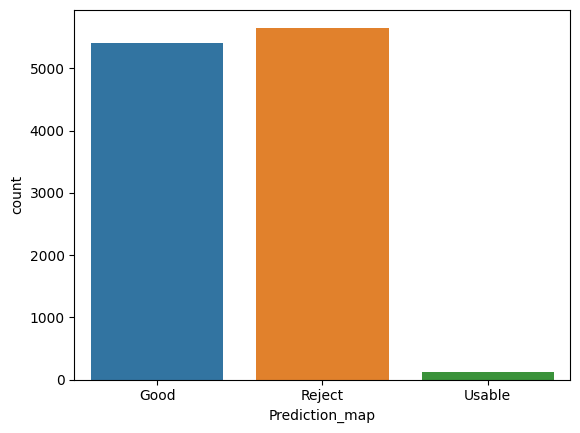

In [ ]:
sns.countplot(data = merged_inner, x = 'Prediction_map')

__The gradability is 48%.__

### Pupil size

Grouping based on each visit and per eye

In [ ]:
merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].describe()

count   mean       std   min     25%    50%     75%   max
visit_id eye                                                           
40       l      1.0  4.140       NaN  4.14  4.1400  4.140  4.1400  4.14
         r      2.0  4.385  0.049497  4.35  4.3675  4.385  4.4025  4.42
43       r      1.0  4.560       NaN  4.56  4.5600  4.560  4.5600  4.56
52       l      1.0  4.520       NaN  4.52  4.5200  4.520  4.5200  4.52
         r      1.0  4.490       NaN  4.49  4.4900  4.490  4.4900  4.49
...             ...    ...       ...   ...     ...    ...     ...   ...
18599    r      2.0  5.305  0.077782  5.25  5.2775  5.305  5.3325  5.36
18608    l      1.0  5.440       NaN  5.44  5.4400  5.440  5.4400  5.44
         r      2.0  6.150  0.268701  5.96  6.0550  6.150  6.2450  6.34
18637    l      1.0  5.330       NaN  5.33  5.3300  5.330  5.3300  5.33
         r      2.0  4.965  0.049497  4.93  4.9475  4.965  4.9825  5.00

[7912 rows x 8 columns]

<Axes: >

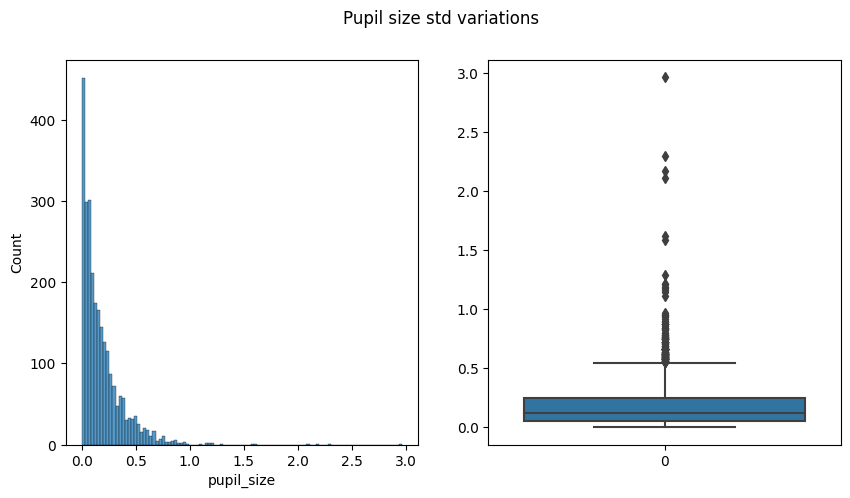

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Pupil size std variations')

sns.histplot(merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].std(), ax = axes[0])
sns.boxplot(merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].std().values, ax = axes[1])

In [ ]:
merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].std().describe()

count    2611.000000
mean        0.183462
std         0.204946
min         0.000000
25%         0.049497
50%         0.120208
75%         0.247487
max         2.962777
Name: pupil_size, dtype: float64

In [ ]:
len(merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].std().sort_values(ascending = False))

7912

In [ ]:
merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].std().sort_values(ascending = False)

visit_id  eye
1924      r      2.962777
3087      l      2.298097
1924      l      2.170818
3034      r      2.107814
14937     l      1.619275
                   ...   
18577     r           NaN
18586     l           NaN
18593     r           NaN
18608     l           NaN
18637     l           NaN
Name: pupil_size, Length: 7912, dtype: float64

https://cloud.oivi.co/visits/14937
- For some patients the change in pupil size for different images is huge
- For visit 14937 the pupil size changed from 4.3 to 6.6

![Screenshot 2023-12-13 at 4.54.10 PM.png](attachment:3ea30dfa-524c-4121-9fbb-db921e671801.png)

Max pupil size for each eye

In [ ]:
merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].max().describe()

count    7912.000000
mean        5.012079
std         1.178545
min         1.800000
25%         4.230000
50%         4.900000
75%         5.630000
max        10.180000
Name: pupil_size, dtype: float64

<Axes: >

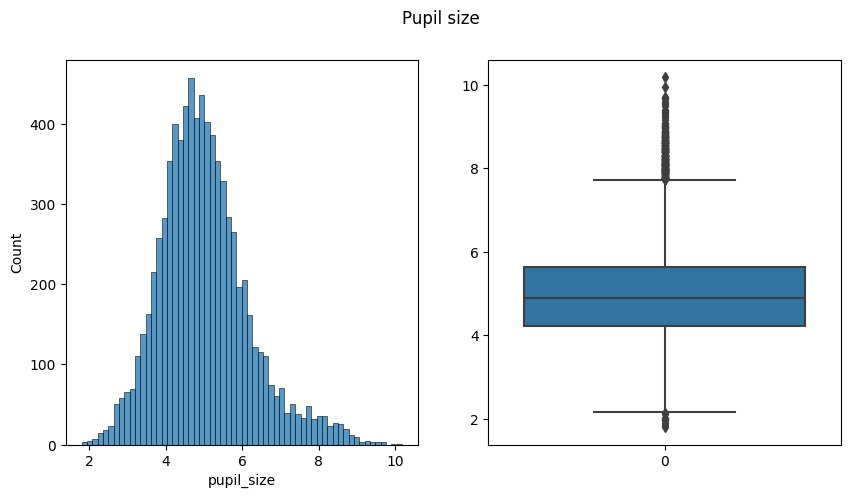

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
fig.suptitle('Pupil size')

sns.histplot(merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].max(), ax = axes[0])
sns.boxplot(merged_inner.groupby(['visit_id', 'eye'])['pupil_size'].max().values,  ax = axes[1])

__Pupil size ranges from 1.8 mm to 10.1mm with a median of 4.9__

In [ ]:
merged_inner.groupby('eye')['pupil_size'].describe()

,count,mean,std,min,25%,50%,75%,max
eye,,,,,,,,
l,5635.0,4.976195,1.268978,1.89,4.10,4.77,5.62,10.18
r,5545.0,5.100069,1.244412,1.78,4.23,4.95,5.80,9.94


In [ ]:
merged_inner.groupby('gaze')['pupil_size'].describe()

,count,mean,std,min,25%,50%,75%,max
gaze,,,,,,,,
center,9533.0,4.951776,1.228095,1.78,4.10,4.80,5.620,10.18
left,99.0,5.525152,1.349592,3.35,4.55,5.28,6.165,9.57
right,1548.0,5.535187,1.313427,2.44,4.52,5.27,6.420,9.66


There does not seem to be much difference in pupil size wrt to eye or gaze, which is expected.

### Dr grading

In [ ]:
merged_inner.groupby(['visit_id', 'eye'])['dr_grading'].value_counts().reset_index()['dr_grading'].value_counts(normalize= True)

dr_grading
Grade 1: No DR            0.564213
Inconclusive              0.331637
Grade 3: Moderate NPDR    0.041895
Grade 2: Mild NPDR        0.031584
Grade 4: Severe NPDR      0.022318
Grade 5: PDR              0.008353
Name: proportion, dtype: float64

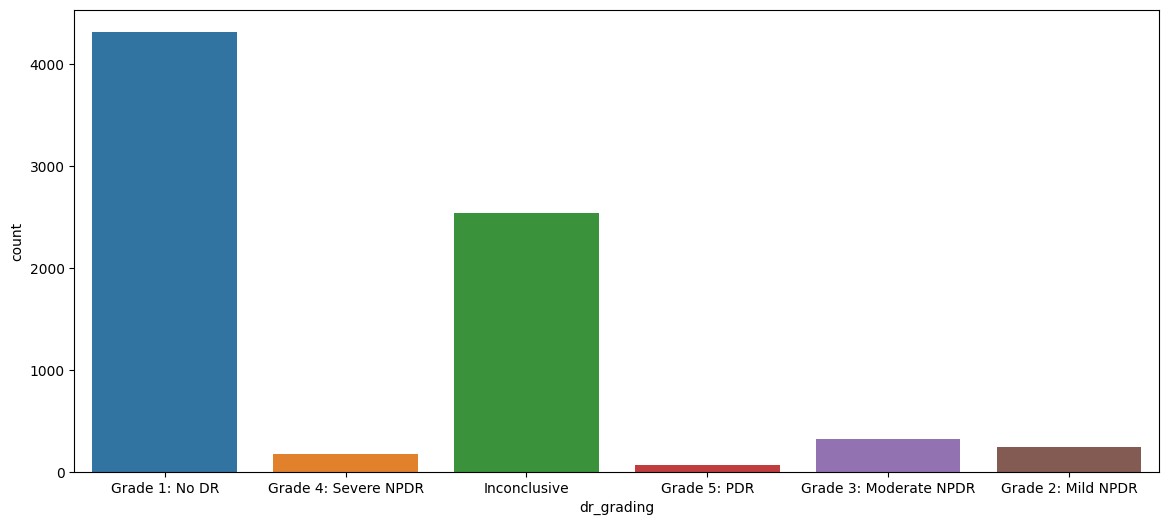

In [ ]:
plt.figure(figsize=(14,6))
ax = sns.countplot(data = merged_inner.groupby(['visit_id', 'eye'])['dr_grading'].value_counts().reset_index(), x = 'dr_grading')


__Approximately 33% eyes are marked as Inconclusive, according to this our gradability is 67%, but gradability model says 58%__

### Gender

In [ ]:
merged_inner.groupby(['visit_id'])['gender'].value_counts().reset_index()['gender'].value_counts(normalize= True)

gender
M         0.530954
F         0.461807
Male      0.004743
Female    0.002496
Name: proportion, dtype: float64

<Axes: xlabel='gender', ylabel='count'>

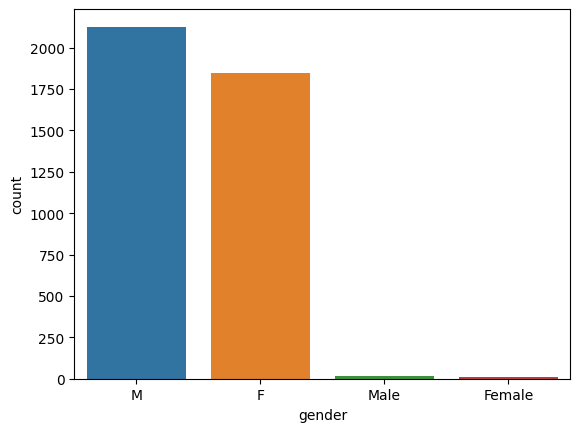

In [ ]:
sns.countplot(data = merged_inner.groupby(['visit_id'])['gender'].value_counts().reset_index(), x = 'gender')

Males represent 53% of population.

### Age

In [ ]:
merged_inner.groupby(['visit_id'])['age'].mean().describe()

count    4006.000000
mean       62.672491
std         8.252572
min        50.000000
25%        56.000000
50%        62.000000
75%        68.000000
max        89.000000
Name: age, dtype: float64

<Axes: >

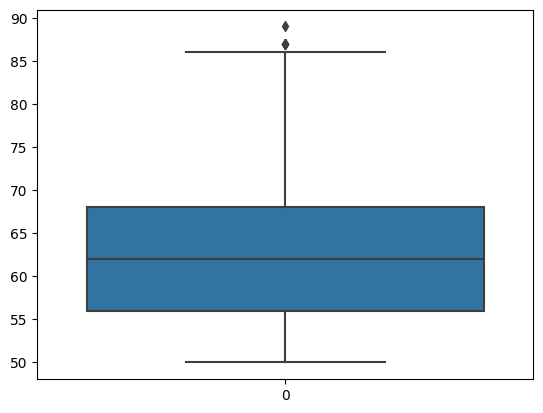

In [ ]:
sns.boxplot(merged_inner.groupby(['visit_id'])['age'].mean().values)

We have patients from 50 to 89 years of age.

In [ ]:
merged_inner.columns

Index(['Name', 'softmax_good', 'softmax_usable', 'softmax_bad', 'good_sd',
       'usable_sd', 'bad_sd', 'Prediction', 'imageid_visitid', 'image_id',
       'visit_id', 'age', 'gender', 'pupil_size', 'eye', 'gaze', 'dm_onset',
       'hypertension_onset', 'cataract_od', 'cataract_os', 'dr_grading_od',
       'dr_grading_os', 'location_name', 'cataract', 'dr_grading',
       'Prediction_map', 'DM', 'HT'],
      dtype='object')

## Bivariate analysis

### Age vs pupil size

<Axes: xlabel='age', ylabel='pupil_size'>

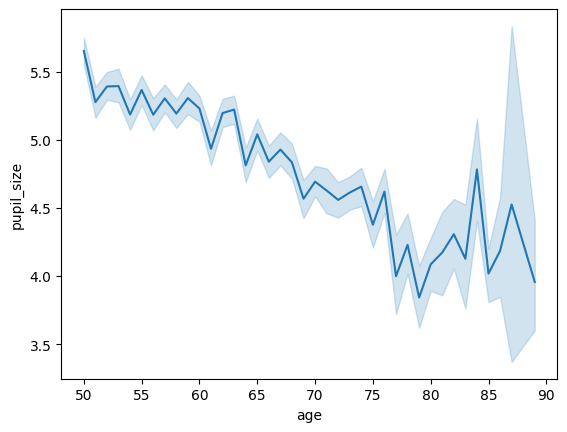

In [ ]:
sns.lineplot(data = merged_inner, x = 'age', y = 'pupil_size')

In general as age increases the pupil size decreases, some of the spikes(especially after 80 years) maybe due to dilation

### Gender vs image Q

In [ ]:
merged_inner['gender'].value_counts()

gender
M         6180
F         4925
Male        46
Female      29
Name: count, dtype: int64

<Axes: xlabel='gender', ylabel='softmax_good'>

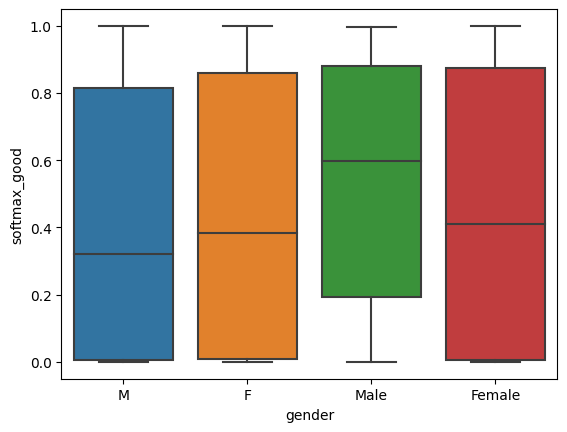

In [ ]:
sns.boxplot(data= merged_inner, x ='gender', y = 'softmax_good')

<Axes: xlabel='gender', ylabel='age'>

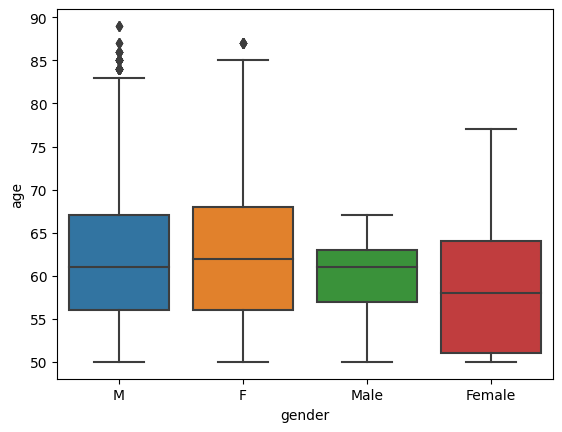

In [ ]:
sns.boxplot(data= merged_inner, x ='gender', y = 'age')

__Females tend to have a slightly better imageQ, eventhough females are older__.

### Location vs image Q (softmax_good)

[Text(0, 0, "{'Minto'}"),
 Text(1, 0, "{'Drishti Eye Hospital-kanakapura '}"),
 Text(2, 0, "{'Lopamudra Hospitals'}"),
 Text(3, 0, "{'Kaveri Healthcare'}"),
 Text(4, 0, "{'Sanket Healthcare-Jayanagar'}"),
 Text(5, 0, "{'Shriram Luxor Screening camp'}"),
 Text(6, 0, '{"Dr Mahesh\'s Diabetic Centre"}'),
 Text(7, 0, "{'KC Hospital'}"),
 Text(8, 0, "{'Oivi Clinic'}"),
 Text(9, 0, "{'Pranav Diabetes Center'}"),
 Text(10, 0, "{'Idrishti@ S S Sparsh Hospital'}"),
 Text(11, 0, "{'Minto at GeneralOPD'}"),
 Text(12, 0, "{'Dwarakanath Screening Camp'}"),
 Text(13, 0, "{'Minto Trials DV2'}"),
 Text(14, 0, "{'HBS HOSPITAL Screening camp '}"),
 Text(15, 0, "{'Anugraha Diabetes & Endocrinology Center'}"),
 Text(16, 0, "{'Idrishti@Apollo clinic-Sarjapur'}"),
 Text(17, 0, "{'NURA AI Health Screening Center Bengaluru'}"),
 Text(18, 0, "{'OPHTHALL 2023'}"),
 Text(19, 0, "{'KSRP Electronic City Battalion - B'}"),
 Text(20, 0, "{'KSRP Electronic City Battalion - A'}"),
 Text(21, 0, "{'Manjunatha nethralaya

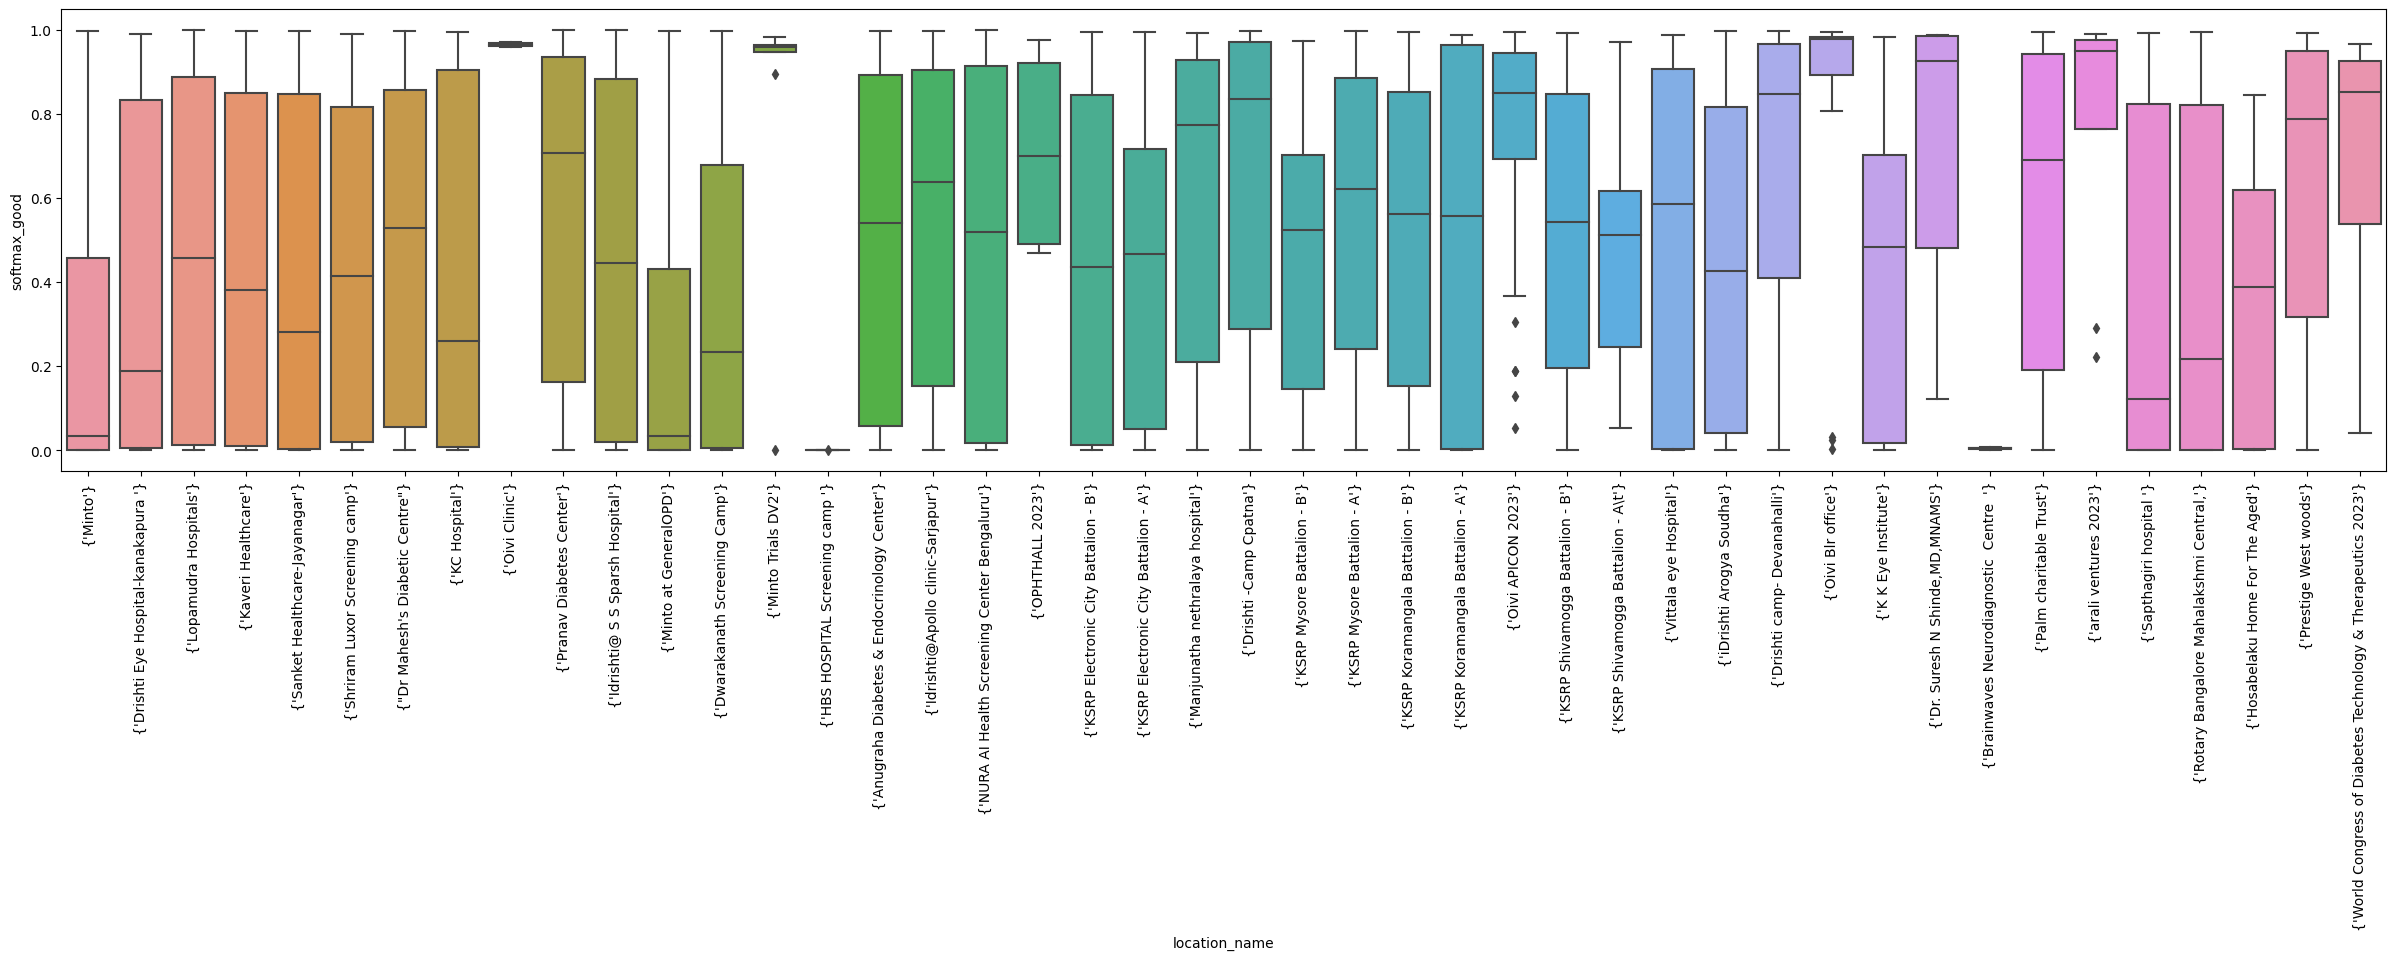

In [ ]:
plt.figure(figsize=(30,6))
ax = sns.boxplot(x ='location_name', y ='softmax_good', data = merged_inner)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [ ]:
ct_table_ind=pd.crosstab(merged_inner["Prediction_map"],merged_inner["location_name"])
ct_table_ind

location_name,"{""Dr Mahesh's Diabetic Centre""}",{'Anugraha Diabetes & Endocrinology Center'},{'Brainwaves Neurodiagnostic Centre '},"{'Dr. Suresh N Shinde,MD,MNAMS'}",{'Drishti -Camp Cpatna'},{'Drishti Eye Hospital-kanakapura '},{'Drishti camp- Devanahalli'},{'Dwarakanath Screening Camp'},{'HBS HOSPITAL Screening camp '},{'Hosabelaku Home For The Aged'},...,{'Pranav Diabetes Center'},{'Prestige West woods'},"{'Rotary Bangalore Mahalakshmi Central,'}",{'Sanket Healthcare-Jayanagar'},{'Sapthagiri hospital '},{'Shriram Luxor Screening camp'},{'Vittala eye Hospital'},{'World Congress of Diabetes Technology & Therapeutics 2023'},{'arali ventures 2023'},{'iDrishti Arogya Soudha'}
Prediction_map,,,,,,,,,,,,,,,,,,,,,
Good,302,128,0,9,19,58,9,135,0,4,...,109,20,12,187,106,27,27,10,6,35
Reject,227,89,4,3,7,79,2,187,4,5,...,59,9,19,225,144,23,22,2,2,30
Usable,11,4,0,0,0,2,0,2,0,0,...,0,0,0,7,1,2,1,0,0,0


In [ ]:
ct_table_ind.iloc[0][27], ct_table_ind.iloc[1][27], ct_table_ind.iloc[2][27]

(592, 1518, 29)

In [ ]:
ct_table_ind.columns[27]

"{'Minto'}"

In [ ]:
ct_table_ind.values

array([[ 302,  128,    0,    9,   19,   58,    9,  135,    0,    4,  697,
          65,   23,   39,   31,   24,    4,  157,  141,   24,    5,  161,
         139, 1836,    9,    8,   42,  592,   90,    4,   36,   14,    2,
          58,  109,   20,   12,  187,  106,   27,   27,   10,    6,   35],
       [ 227,   89,    4,    3,    7,   79,    2,  187,    4,    5,  622,
          37,   21,   43,   25,   20,    4,   81,   68,   16,    3,  104,
         137, 1599,    5,    1,  109, 1518,   68,    0,    4,    3,    0,
          26,   59,    9,   19,  225,  144,   23,   22,    2,    2,   30],
       [  11,    4,    0,    0,    0,    2,    0,    2,    0,    0,   10,
           1,    0,    1,    0,    1,    0,    4,    2,    0,    0,    1,
           6,   26,    0,    0,    4,   29,    1,    0,    2,    0,    0,
           2,    0,    0,    0,    7,    1,    2,    1,    0,    0,    0]])

There are few clinics where the image quality is much lower compared to other clinics, like __Minto just has 28% gradability__. Need to explore more on the reasons for this!!

### HT vs imageQ (softmax_good)

[Text(0.5, 1.0, 'age vs imageQ')]

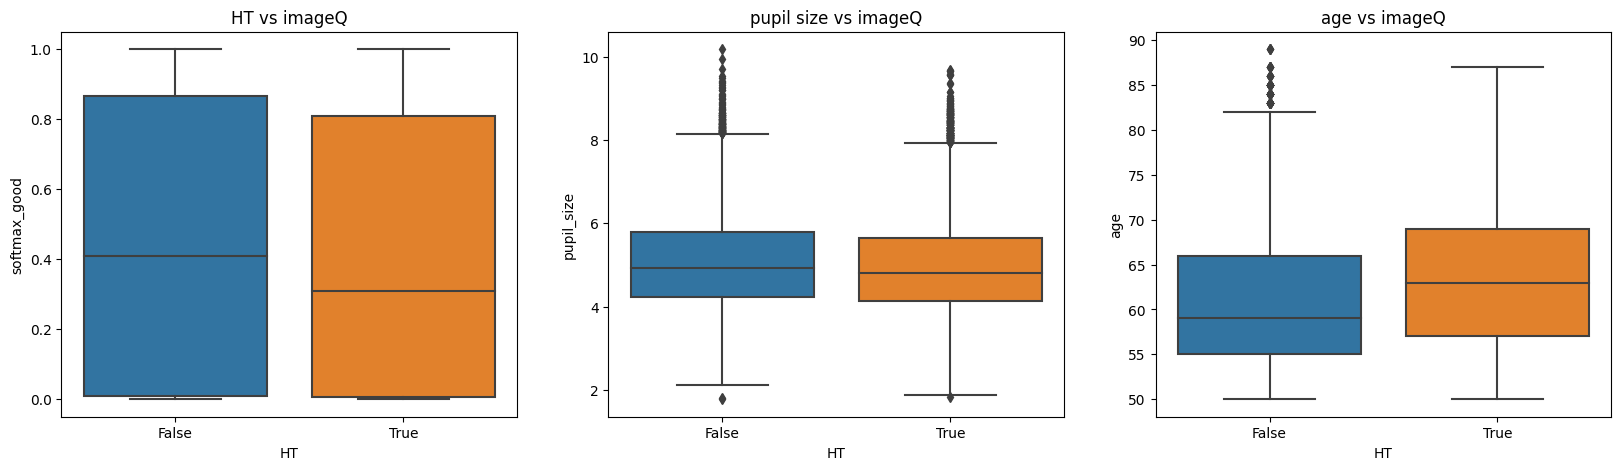

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))


sns.boxplot(x ='HT', y ='softmax_good', data = merged_inner, ax = axes[0]).set(title = 'HT vs imageQ')
sns.boxplot(x ='HT', y ='pupil_size', data = merged_inner, ax = axes[1]).set(title = 'pupil size vs imageQ')
sns.boxplot(x ='HT', y ='age', data = merged_inner, ax = axes[2]).set(title = 'age vs imageQ')

_There seems to a case that people with HT have lower imageQ while no significant difference in pupil_size, but we see that pupil with HT are older, which means possible cataract leading to lower imageQ ?_

Running Chi-Square test to confirm

In [ ]:
ct_table_ind=pd.crosstab(merged_inner["Prediction_map"],merged_inner["HT"])

In [ ]:
ct_table_ind

HT,False,True
Prediction_map,,
Good,2369,3035
Reject,2224,3432
Usable,51,69


In [ ]:
chi2_stat, p, dof, expected = scipy.stats.chi2_contingency(ct_table_ind)

In [ ]:
p

8.878910696540086e-06

__A p-value of <0.05 confirms there is some relationship between imageQ and HT. But need to explore is this is due to some other correlations__

### Digging more into what causes low gradability

__Removing pupil size < 4mm and checking gradability__

In [ ]:
merged_inner_big_pupil = merged_inner[merged_inner['pupil_size'] >= 4]
merged_inner_small_pupil = merged_inner[merged_inner['pupil_size'] < 4]

In [ ]:
merged_inner.shape, merged_inner_big_pupil.shape, merged_inner_small_pupil.shape

((11180, 28), (8996, 28), (2184, 28))

In [ ]:
merged_inner['Prediction_map'].value_counts(normalize= True)

Prediction_map
Reject    0.505903
Good      0.483363
Usable    0.010733
Name: proportion, dtype: float64

In [ ]:
merged_inner_big_pupil['Prediction_map'].value_counts(normalize= True)

Prediction_map
Good      0.581703
Reject    0.409627
Usable    0.008671
Name: proportion, dtype: float64

In [ ]:
merged_inner_small_pupil['Prediction_map'].value_counts(normalize= True)

Prediction_map
Reject    0.902473
Good      0.078297
Usable    0.019231
Name: proportion, dtype: float64

- For all visits the gradability percent is 48%
- For visits with pupil >=4 the gradability percent is 58%
- For visits with pupil <4 the gradability percent is 7.8%

[Text(0.5, 1.0, 'Pupil size<4, gradable 7.8%')]

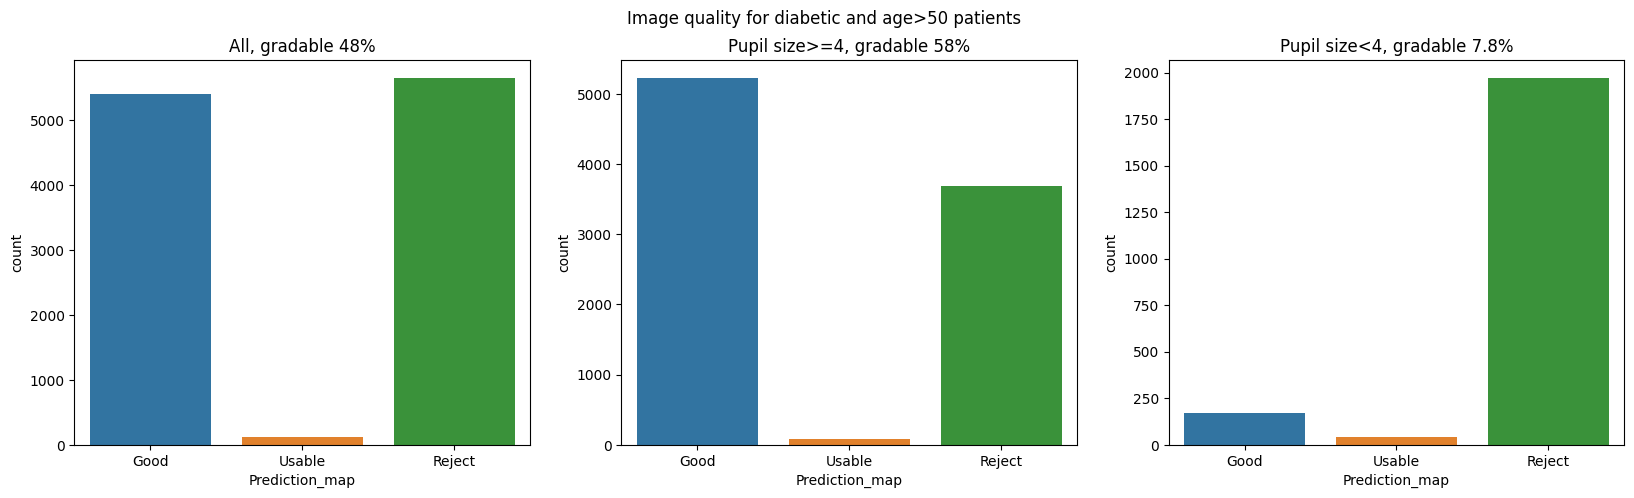

In [ ]:
fig, axes = plt.subplots(1, 3, figsize = (20, 5))
fig.suptitle('Image quality for diabetic and age>50 patients')

order = ['Good', 'Usable', 'Reject']
sns.countplot(data = merged_inner, x = 'Prediction_map', order=order, ax = axes[0]).set(title = 'All, gradable 48%')
sns.countplot(data = merged_inner_big_pupil, x = 'Prediction_map',  order=order, ax = axes[1]).set(title = 'Pupil size>=4, gradable 58%')
sns.countplot(data = merged_inner_small_pupil, x = 'Prediction_map',  order=order, ax = axes[2]).set(title = 'Pupil size<4, gradable 7.8%')


[Text(0, 0, 'Grade 1: No DR'),
 Text(1, 0, 'Inconclusive'),
 Text(2, 0, 'Grade 3: Moderate NPDR'),
 Text(3, 0, 'Grade 4: Severe NPDR'),
 Text(4, 0, 'Grade 5: PDR'),
 Text(5, 0, 'Grade 2: Mild NPDR')]

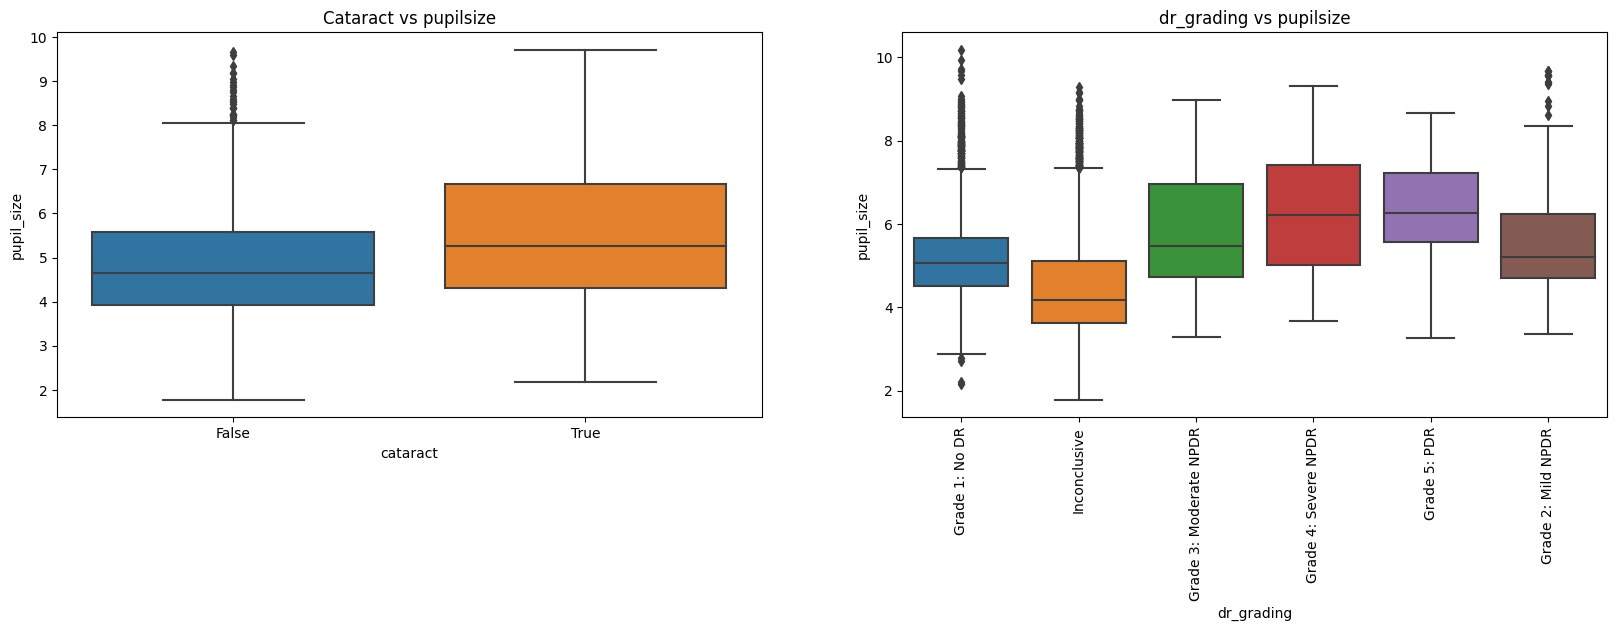

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20, 5))


sns.boxplot(x ='cataract', y ='pupil_size', data = merged_inner, ax = axes[0]).set(title = 'Cataract vs pupilsize')
sns.boxplot(x ='dr_grading', y ='pupil_size', data = merged_inner, ax = axes[1]).set(title = 'dr_grading vs pupilsize')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=90)

- People who have cataract seems to have a higher pupil size
- The inconclusive eyes seems to have a lower pupil size in comparison.

### Take best image from each eye and compare

In [ ]:
custom_order = {'Good': 0, 'Usable': 1, 'Reject' : 2}

In [ ]:
def custom_sort(series):
    return series.map(custom_order)

In [ ]:
merged_inner.sort_values(by = 'Prediction_map', key = custom_sort).groupby(['visit_id', 'eye'])['Prediction_map'].value_counts()

visit_id  eye  Prediction_map
40        l    Good              1
          r    Good              2
43        r    Good              1
52        l    Good              1
          r    Good              1
                                ..
18599     r    Good              1
18608     l    Reject            1
          r    Reject            2
18637     l    Good              1
          r    Good              2
Name: count, Length: 8544, dtype: int64

In [ ]:
best_eye_df = merged_inner.sort_values(by = 'Prediction_map', key = custom_sort).groupby(['visit_id', 'eye']).first().reset_index()

In [ ]:
best_eye_df.shape

(7912, 28)

In [ ]:
best_eye_df['Prediction_map'].value_counts(normalize= True)

Prediction_map
Good      0.580005
Reject    0.411527
Usable    0.008468
Name: proportion, dtype: float64

[Text(0.5, 1.0, 'All visits, but best eye ')]

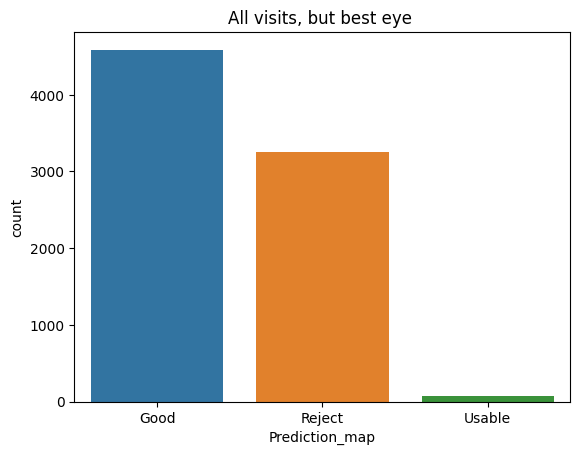

In [ ]:
sns.countplot(data = best_eye_df, x = 'Prediction_map').set(title = 'All visits, but best eye ')

__With just taking the best eye the gradability increased from 48% to 58% for all visits.__

Trying to go little finer and measuring gradability in steps of 0.1mm

In [ ]:
bins = { 0: 'All',
        3.5: '>=3.5',
        3.6: '>=3.6',
        3.7: '>=3.7',
        3.8: '>=3.8',
        3.9: '>=3.9',
        4.0: '>=4',
        4.1: '>=4.1',
        4.2: '>=4.2',
        4.3: '>=4.3',
        4.4: '>=4.4',
        4.5: '>=4.5',
        4.6: '>=4.6',
        4.7: '>=4.7',
        4.8: '>=4.8',
        4.9: '>=4.9',
        5.0: '>=5.0',
        5.1: '>=5.1',
        5.2: '>=5.2',
        5.3: '>=5.3',
        5.4: '>=5.4',
        5.5: '>=5.5',
        5.6: '>=5.6',
        5.7: '>=5.7',
        5.8: '>=5.8',
        5.9: '>=5.9',
        6.0: '>=6.0',
        6.1: '>=6.1',
        6.2: '>=6.2',
        6.3: '>=6.3',
        6.4: '>=6.4',
        6.5: '>=6.5',
        6.6: '>=6.6',
        7.0: '>=7.0',
        8.0: '>=8.0',
}

In [ ]:
imageq_pupilsize = {}
for k in bins:
    tmp = best_eye_df[best_eye_df['pupil_size'] >= k]
    imageq_pupilsize[bins[k]] = tmp['Prediction_map'].value_counts(normalize= True)['Good']

In [ ]:
imageq_pupilsize

{'All': 0.580005055611729,
 '>=3.5': 0.6290899092658785,
 '>=3.6': 0.640425829948172,
 '>=3.7': 0.6525350902320252,
 '>=3.8': 0.6663242846661775,
 '>=3.9': 0.6805198730542542,
 '>=4': 0.6935206869633099,
 '>=4.1': 0.7052256916356576,
 '>=4.2': 0.7148900169204738,
 '>=4.3': 0.7230440206736767,
 '>=4.4': 0.7273408239700374,
 '>=4.5': 0.7343348487843447,
 '>=4.6': 0.7379499052830983,
 '>=4.7': 0.7421539850982163,
 '>=4.8': 0.7430589381393083,
 '>=4.9': 0.74140625,
 '>=5.0': 0.7427762039660056,
 '>=5.1': 0.7411764705882353,
 '>=5.2': 0.7384407694903814,
 '>=5.3': 0.7342192691029901,
 '>=5.4': 0.7264922322158627,
 '>=5.5': 0.7172538392050587,
 '>=5.6': 0.7044656297039639,
 '>=5.7': 0.6949720670391062,
 '>=5.8': 0.6752190237797246,
 '>=5.9': 0.6570218772053634,
 '>=6.0': 0.6416275430359938,
 '>=6.1': 0.6339130434782608,
 '>=6.2': 0.62109375,
 '>=6.3': 0.5984682713347921,
 '>=6.4': 0.5802615933412604,
 '>=6.5': 0.5673202614379085,
 '>=6.6': 0.5505952380952381,
 '>=7.0': 0.4978448275862069,
 '

/var/folders/1k/bj5mq31s7bd97_v3h8y06gr80000gn/T/ipykernel_63292/1161648808.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


[Text(0.5, 0, 'Pupil size >'), Text(0, 0.5, 'Gradable percentage')]

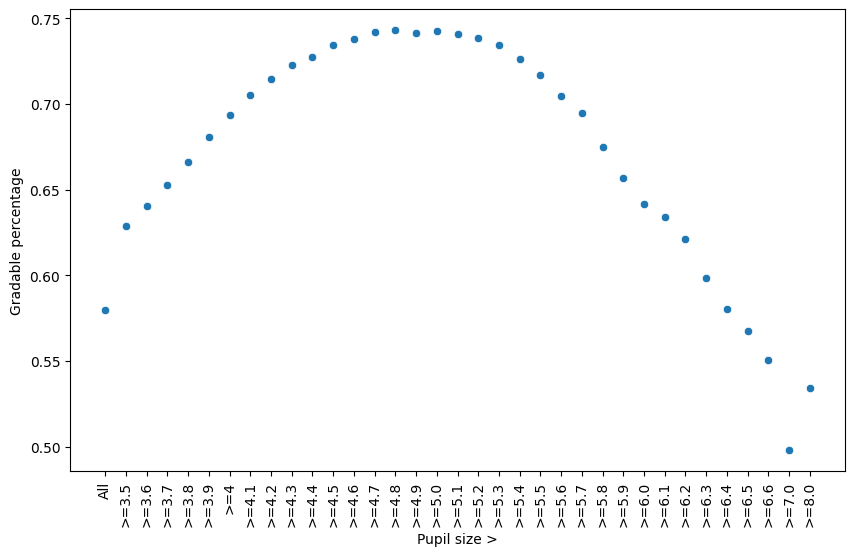

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(imageq_pupilsize)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set(xlabel='Pupil size >', ylabel='Gradable percentage')

__It's hard to explain an inverted U-shape curve , as we expect imageQ to either keep increasing or flatten after a certain pupil size.__

_Making bins of 0.1mm and measuring imageQ within those bins to get an idea, which samples are pulling imageQ down._

In [ ]:
pupil_bins = np.arange(3.5, 9, 0.1)
pupil_bins

array([3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
       4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ,
       6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3,
       7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6,
       8.7, 8.8, 8.9])

In [ ]:
bin_width = 0.1
imageq_pupilbins = {}
population_pupilbins = {}
for i in range(len(pupil_bins)):
    bin = pupil_bins[i]
    bin = np.round(bin, 1)
    tmp = best_eye_df[(best_eye_df['pupil_size'] >= bin) & (best_eye_df['pupil_size'] < (bin+ bin_width))]
    imageq_pupilbins[f"({bin:.1f},{bin + bin_width:.1f}]"] = tmp['Prediction_map'].value_counts(normalize= True)['Good']
    population_pupilbins[f"({bin:.1f},{bin + bin_width:.1f}]"] = len(tmp)

In [ ]:
imageq_pupilbins

{'(3.5,3.6]': 0.02962962962962963,
 '(3.6,3.7]': 0.10191082802547771,
 '(3.7,3.8]': 0.08791208791208792,
 '(3.8,3.9]': 0.1919191919191919,
 '(3.9,4.0]': 0.28773584905660377,
 '(4.0,4.1]': 0.3705357142857143,
 '(4.1,4.2]': 0.4944649446494465,
 '(4.2,4.3]': 0.5618729096989966,
 '(4.3,4.4]': 0.6383763837638377,
 '(4.4,4.5]': 0.6014234875444839,
 '(4.5,4.6]': 0.6785714285714286,
 '(4.6,4.7]': 0.6801242236024845,
 '(4.7,4.8]': 0.7306501547987616,
 '(4.8,4.9]': 0.7669172932330827,
 '(4.9,5.0]': 0.7258064516129032,
 '(5.0,5.1]': 0.76,
 '(5.1,5.2]': 0.7715355805243446,
 '(5.2,5.3]': 0.7834645669291339,
 '(5.3,5.4]': 0.8060836501901141,
 '(5.4,5.5]': 0.8146551724137931,
 '(5.5,5.6]': 0.832579185520362,
 '(5.6,5.7]': 0.7881773399014779,
 '(5.7,5.8]': 0.859375,
 '(5.8,5.9]': 0.8176795580110497,
 '(5.9,6.0]': 0.7985611510791367,
 '(6.0,6.1]': 0.7109375,
 '(6.1,6.2]': 0.7380952380952381,
 '(6.2,6.3]': 0.8090909090909091,
 '(6.3,6.4]': 0.8082191780821918,
 '(6.4,6.5]': 0.7105263157894737,
 '(6.5,6.6

In [ ]:
population_pupilbins

{'(3.5,3.6]': 135,
 '(3.6,3.7]': 157,
 '(3.7,3.8]': 182,
 '(3.8,3.9]': 198,
 '(3.9,4.0]': 212,
 '(4.0,4.1]': 224,
 '(4.1,4.2]': 271,
 '(4.2,4.3]': 299,
 '(4.3,4.4]': 271,
 '(4.4,4.5]': 281,
 '(4.5,4.6]': 308,
 '(4.6,4.7]': 322,
 '(4.7,4.8]': 323,
 '(4.8,4.9]': 266,
 '(4.9,5.0]': 310,
 '(5.0,5.1]': 300,
 '(5.1,5.2]': 267,
 '(5.2,5.3]': 254,
 '(5.3,5.4]': 263,
 '(5.4,5.5]': 232,
 '(5.5,5.6]': 221,
 '(5.6,5.7]': 203,
 '(5.7,5.8]': 192,
 '(5.8,5.9]': 181,
 '(5.9,6.0]': 139,
 '(6.0,6.1]': 128,
 '(6.1,6.2]': 126,
 '(6.2,6.3]': 110,
 '(6.3,6.4]': 73,
 '(6.4,6.5]': 76,
 '(6.5,6.6]': 93,
 '(6.6,6.7]': 58,
 '(6.7,6.8]': 61,
 '(6.8,6.9]': 45,
 '(6.9,7.0]': 44,
 '(7.0,7.1]': 38,
 '(7.1,7.2]': 31,
 '(7.2,7.3]': 23,
 '(7.3,7.4]': 34,
 '(7.4,7.5]': 27,
 '(7.5,7.6]': 27,
 '(7.6,7.7]': 24,
 '(7.7,7.8]': 34,
 '(7.8,7.9]': 18,
 '(7.9,8.0]': 34,
 '(8.0,8.1]': 25,
 '(8.1,8.2]': 26,
 '(8.2,8.3]': 25,
 '(8.3,8.4]': 14,
 '(8.4,8.5]': 17,
 '(8.5,8.6]': 14,
 '(8.6,8.7]': 11,
 '(8.7,8.8]': 12,
 '(8.8,8.9]': 3,
 

In [ ]:
## Check population below 3mm
tmp = best_eye_df[(best_eye_df['pupil_size'] <= 3.0) ]
tmp.shape

(231, 28)

In [ ]:
best_eye_df.shape

(7912, 28)

In [ ]:
tmp.shape[0]/best_eye_df.shape[0]*100

2.9196157735085944

- __Less than 3% eyes are below 3mm__

(2,)


/var/folders/1k/bj5mq31s7bd97_v3h8y06gr80000gn/T/ipykernel_63292/3759939582.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)
/var/folders/1k/bj5mq31s7bd97_v3h8y06gr80000gn/T/ipykernel_63292/3759939582.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=90)


[Text(0.5, 0, 'Pupil bins'), Text(0, 0.5, 'Num of eyes')]

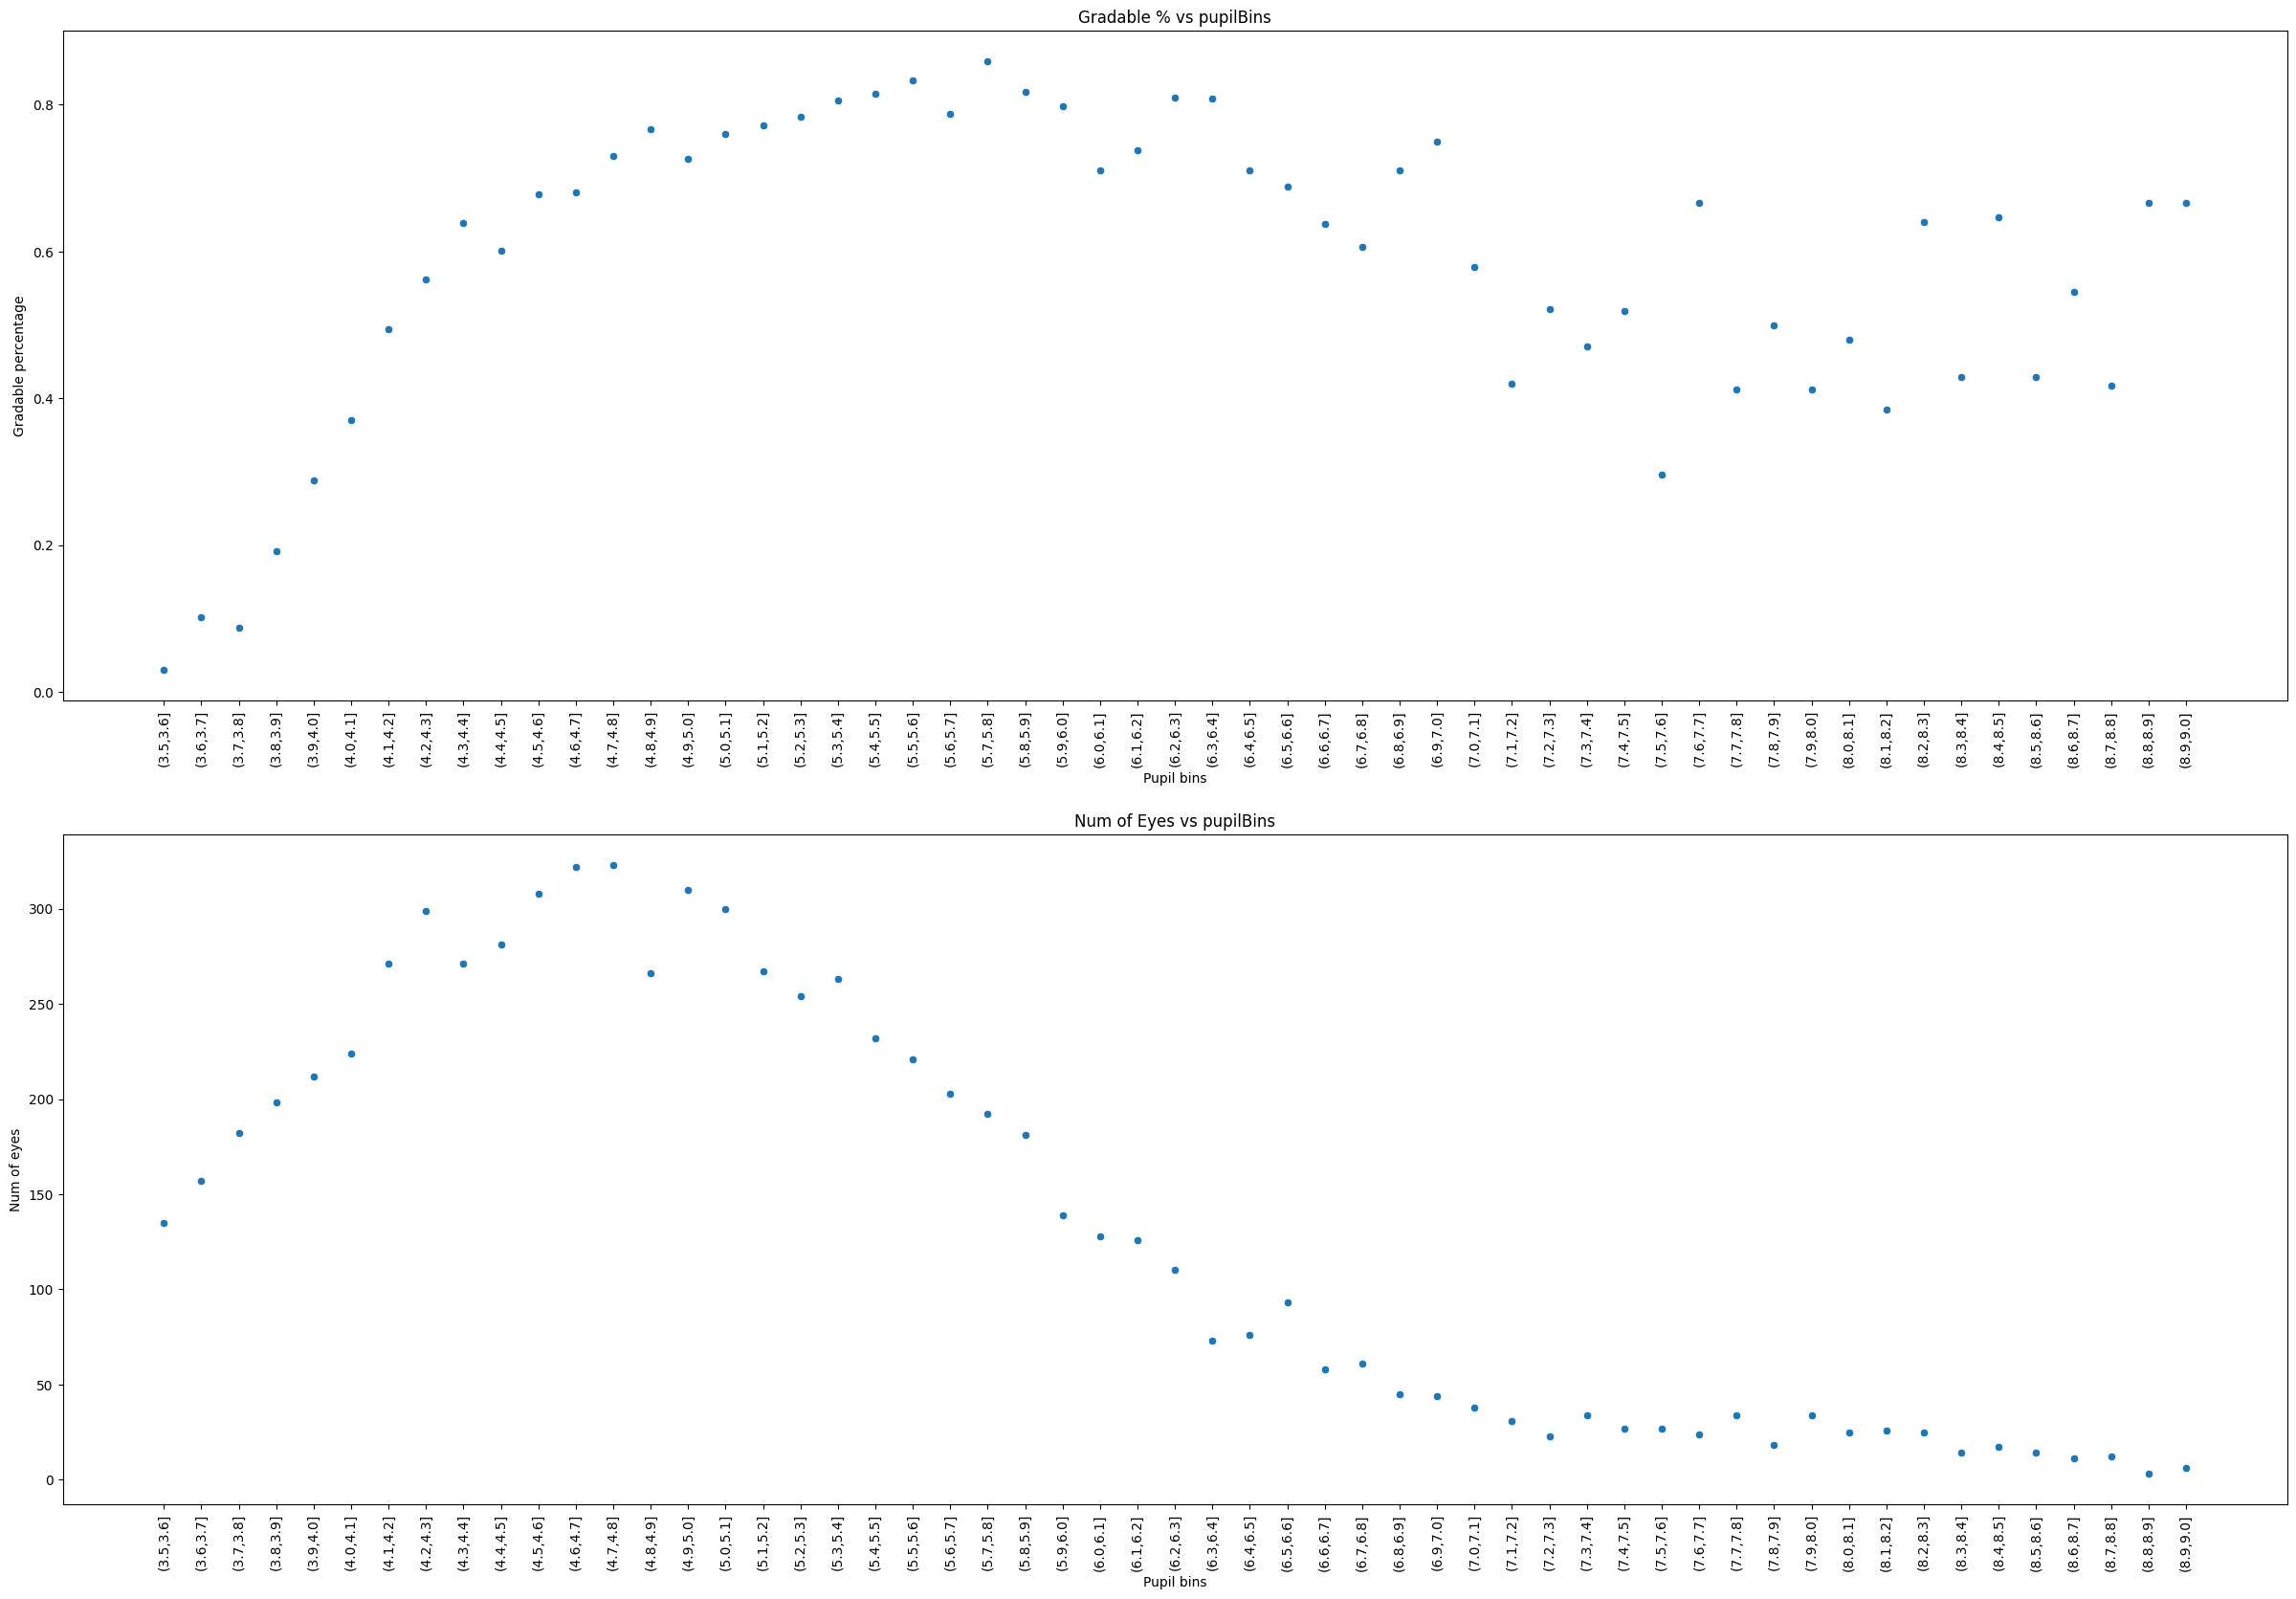

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (30, 20))
print(axes.shape)

sns.scatterplot(imageq_pupilbins, ax = axes[0]).set(title = 'Gradable % vs pupilBins')
sns.scatterplot(population_pupilbins, ax = axes[1]).set(title = 'Num of Eyes vs pupilBins')
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=90)
axes[0].set(xlabel='Pupil bins', ylabel='Gradable percentage')
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=90)
axes[1].set(xlabel='Pupil bins', ylabel='Num of eyes')

- __Small pupil mode to start from 4.5 mm ?__
- Most of the patients fall between 4 -5.5 mm pupil size.
- Between pupil 7.5 and 7.6 it the gradable percent seems to be pretty bad. Try looking into individual images

In [ ]:
bin = 7.5
bin_width = 0.1
tmp = best_eye_df[(best_eye_df['pupil_size'] >= bin) & (best_eye_df['pupil_size'] < (bin+ bin_width))]
print(len(tmp))
tmp['Prediction_map'].value_counts(normalize = True)

27


Prediction_map
Reject    0.703704
Good      0.296296
Name: proportion, dtype: float64

In [ ]:
tmp.shape

(27, 28)

In [ ]:
tmp[tmp['Prediction_map'] == 'Reject'].shape

(19, 28)

In [ ]:
tmp[tmp['Prediction_map'] == 'Reject'].tail(10)

,visit_id,eye,Name,softmax_good,softmax_usable,softmax_bad,good_sd,usable_sd,bad_sd,Prediction,...,cataract_od,cataract_os,dr_grading_od,dr_grading_os,location_name,cataract,dr_grading,Prediction_map,DM,HT
1820,3737,l,../Results/M0/images/production_6617_3737_ai_1...,0.298833,0.214333,0.486834,0.260782,0.134283,0.343421,2,...,None,None,Grade 3: Moderate NPDR,Grade 2: Mild NPDR,{'Lopamudra Hospitals'},None,Grade 2: Mild NPDR,Reject,True,True
2692,5053,l,../Results/M0/images/production_9514_5053_ai_1...,0.000083,0.005277,0.994640,0.000135,0.005625,0.005736,2,...,None,None,Grade 3: Moderate NPDR,Grade 3: Moderate NPDR,{'Minto'},None,Grade 3: Moderate NPDR,Reject,True,False
3044,5593,r,../Results/M0/images/production_10948_5593_ai_...,0.000039,0.003630,0.996332,0.000079,0.003462,0.003524,2,...,None,None,Inconclusive,Inconclusive,{'Minto'},None,Inconclusive,Reject,True,False
3673,6783,r,../Results/M0/images/production_14164_6783_ai_...,0.060391,0.122966,0.816643,0.083221,0.113607,0.195392,2,...,None,None,Inconclusive,Inconclusive,{'Minto'},None,Inconclusive,Reject,True,False
4626,8745,l,../Results/M0/images/production_19540_8745_ai_...,0.002484,0.025473,0.972043,0.006163,0.045538,0.051618,2,...,None,True,Inconclusive,Inconclusive,{'Minto'},True,Inconclusive,Reject,True,True
5409,10707,r,../Results/M0/images/production_23805_10707_ai...,0.036770,0.140560,0.822669,0.036108,0.106528,0.142268,2,...,True,True,Grade 4: Severe NPDR,Grade 3: Moderate NPDR,{'Minto'},True,Grade 4: Severe NPDR,Reject,True,True
5964,12652,l,../Results/M0/images/production_29149_12652_ai...,0.194082,0.283204,0.522714,0.175259,0.168010,0.333786,2,...,True,None,Inconclusive,Inconclusive,{'Minto'},None,Inconclusive,Reject,True,True
7122,16473,l,../Results/M0/images/production_40667_16473_ai...,0.002915,0.024014,0.973071,0.005510,0.027978,0.033023,2,...,None,None,Inconclusive,Inconclusive,{'Minto'},None,Inconclusive,Reject,True,False
7219,16672,l,../Results/M0/images/production_41272_16672_ai...,0.000065,0.003634,0.996301,0.000148,0.004316,0.004455,2,...,None,True,Grade 2: Mild NPDR,Inconclusive,{'Minto'},True,Inconclusive,Reject,True,False
7694,17976,l,../Results/M0/images/production_44752_17976_ai...,0.025619,0.137389,0.836991,0.043657,0.150437,0.180503,2,...,None,None,Inconclusive,Inconclusive,{'Minto'},None,Inconclusive,Reject,True,True


__Some of these images do look bad, possible cataract which is not noted maybe ?__

### Trying to see if higher age have lower imageQ

[Text(0.5, 1.0, 'Age vs cataract')]

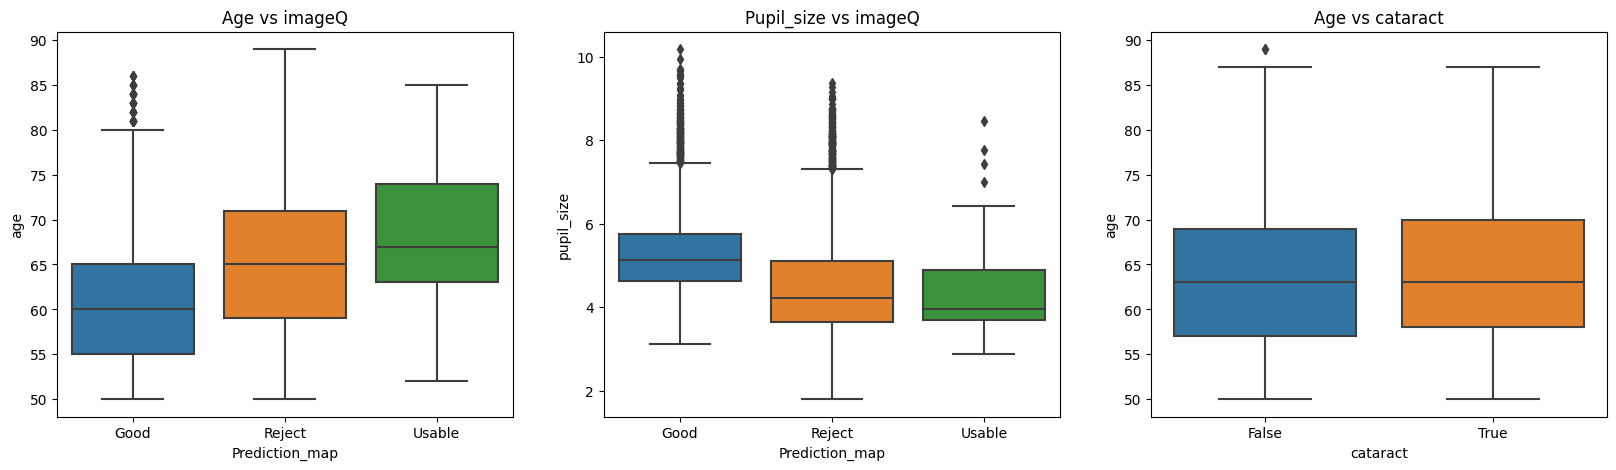

In [ ]:
fig, axes = plt.subplots(1,3 , figsize = (20, 5))


sns.boxplot(data= best_eye_df, x = 'Prediction_map', y = 'age', ax = axes[0]).set(title = 'Age vs imageQ')
sns.boxplot(data= best_eye_df, x = 'Prediction_map', y = 'pupil_size', ax = axes[1]).set(title = 'Pupil_size vs imageQ')
sns.boxplot(data= best_eye_df, x = 'cataract', y = 'age', ax = axes[2]).set(title = 'Age vs cataract')


[Text(0.5, 1.0, 'ImageQ vs Age')]

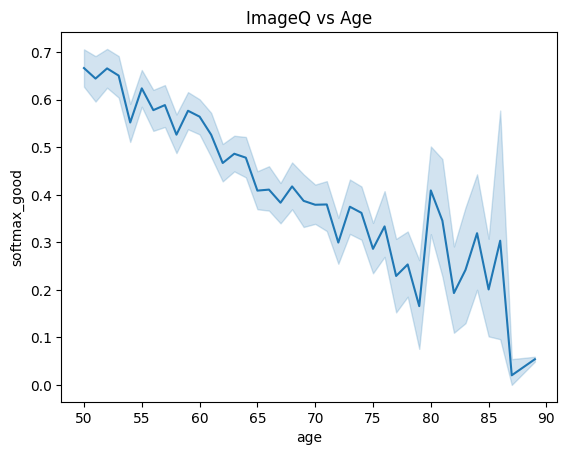

In [ ]:
sns.lineplot(data = best_eye_df, x='age', y = 'softmax_good').set(title = 'ImageQ vs Age')

- As the age increases the imageQ decreases.
- Lower pupil size in general tends to have lower imageQ.
- Some very high pupil sizes are still Reject, probably due to cataract or entire image covered with lesions?
- Some low pupil size < 4mm seems to be Good, probably due to optics dics visible?


### Explore images <4mm where image is good

In [ ]:
best_eye_df_small_pupil = best_eye_df[(best_eye_df['pupil_size'] <4) & (best_eye_df['Prediction_map'] == 'Good')]

In [ ]:
best_eye_df_small_pupil.shape

(147, 28)

- There are 147 images where pupil_size <4mm but still model says a good image.

In [ ]:
best_eye_df_small_pupil.head(10)

,visit_id,eye,Name,softmax_good,softmax_usable,softmax_bad,good_sd,usable_sd,bad_sd,Prediction,...,cataract_od,cataract_os,dr_grading_od,dr_grading_os,location_name,cataract,dr_grading,Prediction_map,DM,HT
31,1047,r,../Results/M0/images/production_1241_1047_ai_1...,0.856208,0.101416,0.042376,0.144938,0.088672,0.081798,0,...,False,False,Grade 1: No DR,Grade 1: No DR,{'Kaveri Healthcare'},False,Grade 1: No DR,Good,True,False
32,1092,l,../Results/M0/images/production_1292_1092_ai_1...,0.702206,0.173995,0.123799,0.237501,0.123193,0.164889,0,...,False,False,Grade 1: No DR,Grade 3: Moderate NPDR,{'Sanket Healthcare-Jayanagar'},False,Grade 3: Moderate NPDR,Good,True,False
41,1119,r,../Results/M0/images/production_1340_1119_ai_1...,0.524421,0.297377,0.178202,0.192102,0.097509,0.135756,0,...,True,True,Grade 1: No DR,Grade 1: No DR,{'Sanket Healthcare-Jayanagar'},True,Grade 1: No DR,Good,True,True
63,1153,r,../Results/M0/images/production_1391_1153_ai_1...,0.519644,0.200890,0.279466,0.294136,0.089961,0.274025,0,...,False,False,Grade 3: Moderate NPDR,Grade 3: Moderate NPDR,{'Sanket Healthcare-Jayanagar'},False,Grade 3: Moderate NPDR,Good,True,True
77,1162,r,../Results/M0/images/production_1422_1162_ai_1...,0.341585,0.322760,0.335655,0.256856,0.159277,0.319574,0,...,False,False,Inconclusive,Inconclusive,{'Sanket Healthcare-Jayanagar'},False,Inconclusive,Good,True,True
152,1225,r,../Results/M0/images/production_1607_1225_ai_1...,0.367652,0.322734,0.309614,0.252309,0.110704,0.217773,0,...,False,False,Grade 1: No DR,Grade 1: No DR,{'Sanket Healthcare-Jayanagar'},False,Grade 1: No DR,Good,True,False
195,1274,r,../Results/M0/images/production_1778_1274_ai_1...,0.850386,0.112806,0.036808,0.138413,0.090130,0.050068,0,...,False,False,Grade 1: No DR,Grade 1: No DR,"{""Dr Mahesh's Diabetic Centre""}",False,Grade 1: No DR,Good,True,False
338,1399,l,../Results/M0/images/production_2148_1399_ai_1...,0.423548,0.300711,0.275741,0.195570,0.074082,0.230383,0,...,False,False,Grade 1: No DR,Grade 1: No DR,{'Sanket Healthcare-Jayanagar'},False,Grade 1: No DR,Good,True,True
429,1464,l,../Results/M0/images/production_2371_1464_ai_1...,0.840396,0.095582,0.064022,0.208476,0.085437,0.140346,0,...,False,False,Grade 1: No DR,Grade 1: No DR,{'Sanket Healthcare-Jayanagar'},False,Grade 1: No DR,Good,True,False
436,1491,r,../Results/M0/images/production_2421_1491_ai_1...,0.707671,0.267417,0.024912,0.301657,0.268754,0.033752,0,...,False,True,Grade 1: No DR,Inconclusive,"{""Dr Mahesh's Diabetic Centre""}",False,Grade 1: No DR,Good,True,False


__Few examples where most of the areas are washed out but just optics disc is visible and model says "Good image".__
- https://cloud.oivi.co/visits/1119
![20221129-072343-1340-ai_1800b.jpg](attachment:e25511c3-a26d-4705-82a9-c99000324c5c.jpg)

- https://cloud.oivi.co/visits/1153
![20221206-091509-1391-ai_1800b.jpg](attachment:8597b235-260a-41ef-b0d7-15d9fe5992aa.jpg)

- https://cloud.oivi.co/visits/1225
![20221214-101522-1607-ai_1800b.jpg](attachment:4f328419-7eb9-4b44-94de-90a31853b7f6.jpg)

### Explore images >7mm where image is Reject

In [ ]:
best_eye_df_big_pupil = best_eye_df[(best_eye_df['pupil_size'] >7) & (best_eye_df['Prediction_map'] == 'Reject') & (best_eye_df['cataract'] != True) ]

In [ ]:
best_eye_df_big_pupil.shape

(142, 28)

__There are 142 images of this case__

In [ ]:
best_eye_df_big_pupil.head(10)

,visit_id,eye,Name,softmax_good,softmax_usable,softmax_bad,good_sd,usable_sd,bad_sd,Prediction,...,cataract_od,cataract_os,dr_grading_od,dr_grading_os,location_name,cataract,dr_grading,Prediction_map,DM,HT
159,1236,l,../Results/M0/images/production_1643_1236_ai_1...,0.040306,0.143382,0.816311,0.044308,0.136247,0.180277,2,...,False,False,Grade 5: PDR,Inconclusive,{'Minto'},False,Inconclusive,Reject,True,False
163,1238,l,../Results/M0/images/production_1664_1238_ai_1...,0.013146,0.076341,0.910513,0.027813,0.133205,0.160870,2,...,True,False,Inconclusive,Inconclusive,{'Minto'},False,Inconclusive,Reject,True,False
165,1239,l,../Results/M0/images/production_1672_1239_ai_1...,0.089102,0.188693,0.722205,0.112191,0.104877,0.209327,2,...,False,False,Grade 3: Moderate NPDR,Grade 3: Moderate NPDR,{'Minto'},False,Grade 3: Moderate NPDR,Reject,True,True
166,1239,r,../Results/M0/images/production_1673_1239_ai_1...,0.000303,0.010950,0.988746,0.000502,0.012051,0.012471,2,...,False,False,Grade 3: Moderate NPDR,Grade 3: Moderate NPDR,{'Minto'},False,Grade 3: Moderate NPDR,Reject,True,True
233,1304,r,../Results/M0/images/production_1866_1304_ai_1...,0.066725,0.152939,0.780336,0.088737,0.119143,0.201815,2,...,False,False,Grade 4: Severe NPDR,Grade 4: Severe NPDR,{'Minto'},False,Grade 4: Severe NPDR,Reject,True,True
297,1364,r,../Results/M0/images/production_2032_1364_ai_1...,0.006219,0.051840,0.941941,0.008993,0.055647,0.062627,2,...,False,False,Grade 5: PDR,Grade 5: PDR,{'Minto'},False,Grade 5: PDR,Reject,True,True
301,1366,r,../Results/M0/images/production_2039_1366_ai_1...,0.086620,0.108685,0.804695,0.102708,0.099356,0.196722,2,...,False,False,Grade 4: Severe NPDR,Grade 1: No DR,{'Minto'},False,Grade 4: Severe NPDR,Reject,True,True
316,1376,l,../Results/M0/images/production_2075_1376_ai_1...,0.080347,0.330686,0.588967,0.070008,0.248925,0.301601,2,...,False,False,Grade 4: Severe NPDR,Grade 4: Severe NPDR,{'Minto'},False,Grade 4: Severe NPDR,Reject,True,False
360,1411,l,../Results/M0/images/production_2181_1411_ai_1...,0.000128,0.006774,0.993098,0.000197,0.009039,0.009212,2,...,False,False,Inconclusive,Inconclusive,{'Lopamudra Hospitals'},False,Inconclusive,Reject,True,False
404,1447,r,../Results/M0/images/production_2296_1447_ai_1...,0.000208,0.007424,0.992368,0.000416,0.009357,0.009716,2,...,False,True,Inconclusive,Inconclusive,{'Minto'},False,Inconclusive,Reject,True,True


__Few examples where are lesions in the entire image but model says Reject__

- https://cloud.oivi.co/visits/197
  ![20231125-191013-173-ai_1800b (1).jpg](attachment:7fc0c424-65ad-4b8e-bbc4-858a61177305.jpg)

- https://cloud.oivi.co/visits/897
![20221103-065621-1036-ai_1800b.jpg](attachment:a0125606-ba86-46bf-b212-2f1d753277b5.jpg)

- https://cloud.oivi.co/visits/1236
![20221215-064230-1637-ai_1800b.jpg](attachment:5d5ed138-87e5-48c0-a6f0-85110a06076d.jpg)

__Few examples where pupil_size > 7 but image is blurred, possibly catarct or high power ?__

- https://cloud.oivi.co/visits/1239
![20221215-070423-1672-ai_1800b.jpg](attachment:e936f2fe-98d9-4b48-b7ea-2b1c049e5223.jpg)

- https://cloud.oivi.co/visits/1304
![20221219-052126-1866-ai_1800b.jpg](attachment:2c0a01bd-a970-4975-8050-4dd422b48f15.jpg)

Links to these images-
https://drive.google.com/drive/folders/1CZ7FZxu3-CbS8pNnd-LQaZTBFJ_2EA15?usp=drive_link

## Recommendations

In [ ]:
Insights = ['Sharp increase in imageQ upto 4.5mm pupil.',
            '2.9% eyes below 3mm.',
            'Removing small pupil/catract increases imageQ from 58% to 86%.',
            'Images <4mm with just disc visible graded as Good OR Images >7mm with complete lesions graded as Reject.',
            'Sharp decrease in imageQ and pupil_size with incease in age.',
            'Sharp variation in imageQ across clinics.',
            'Pupil size increase to as high a 2.3mm during capture.'
           ]


In [ ]:
Recommendations = ['Start small pupil from 4.5mm.',
                   'Lowest pupil size to target 3mm.',
                   'Improve small pupil/catract for biggest gain.',
                   "Can't trust automorph gradability model blindly.",
                   "Setting correct diopters can help for big pupil and no cataract.",
                   "Study clinics with low imageQ like Minto/Sapthagiri.",
                   "Closing eyes and retaking images can help for smaller pupil."
                  ]


In [ ]:
# dictionary of lists
pd.set_option('display.max_colwidth', None)
dict = {'Insights': Insights, 'Recommendations': Recommendations}
df = pd.DataFrame(dict)
df.head(df.shape[0])

,Insights,Recommendations
0,Sharp increase in imageQ upto 4.5mm pupil.,Start small pupil from 4.5mm.
1,2.9% eyes below 3mm.,Lowest pupil size to target 3mm.
2,Removing small pupil/catract increases imageQ from 58% to 86%.,Improve small pupil/catract for biggest gain.
3,Images <4mm with just disc visible graded as Good OR Images >7mm with complete lesions graded as Reject.,Can't trust automorph gradability model blindly.
4,Sharp decrease in imageQ and pupil_size with incease in age.,Setting correct diopters can help for big pupil and no cataract.
5,Sharp variation in imageQ across clinics.,Study clinics with low imageQ like Minto/Sapthagiri.
6,Pupil size increase to as high a 2.3mm during capture.,Closing eyes and retaking images can help for smaller pupil.
